In [5]:
import os, copy, h5py
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import numpy as np
import pandas as pd
from syntheticstellarpopconvolve import convolve, default_convolution_config, default_convolution_instruction
from syntheticstellarpopconvolve.general_functions import generate_boilerplate_outputfile, extract_unit_dict, temp_dir
from compas_python_utils.cosmic_integration.ClassCOMPAS import COMPASData
from syntheticstellarpopconvolve.starformation_rate_distributions import starformation_rate_distribution_vanSon2023, madau_dickinson_sfr
from syntheticstellarpopconvolve.metallicity_distributions import metallicity_distribution_vanSon2022, compas_log_skew_normal_distribution_metallicity_distribution
from syntheticstellarpopconvolve.general_functions import calculate_bincenters, calculate_bin_edges
from syntheticstellarpopconvolve.cosmology_utils import lookback_time_to_redshift
from syntheticstellarpopconvolve.SFR_dict_plotting_routines import plot_sfr_dict
import matplotlib.pyplot as plt
from population_vis import get_formation_efficiency
import time
import warnings
import scipy

Let's try and plot the SFRD ourselves, since something is just not going right. From Neijssel we have:
$$\frac{dP}{dZ}(z)=\frac{1}{Z\sigma\sqrt{2\pi}}e^{-\frac{(\ln Z-\mu(z))^2}{2\sigma^2}}$$
Inferring from Langer Norman 2007 and also the code from SSPC, the mean metallicity distribution follows a power law:
$$\mu(z)=\mu_0\times10^{\mu_z\times z}$$

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_19762/2651584725.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


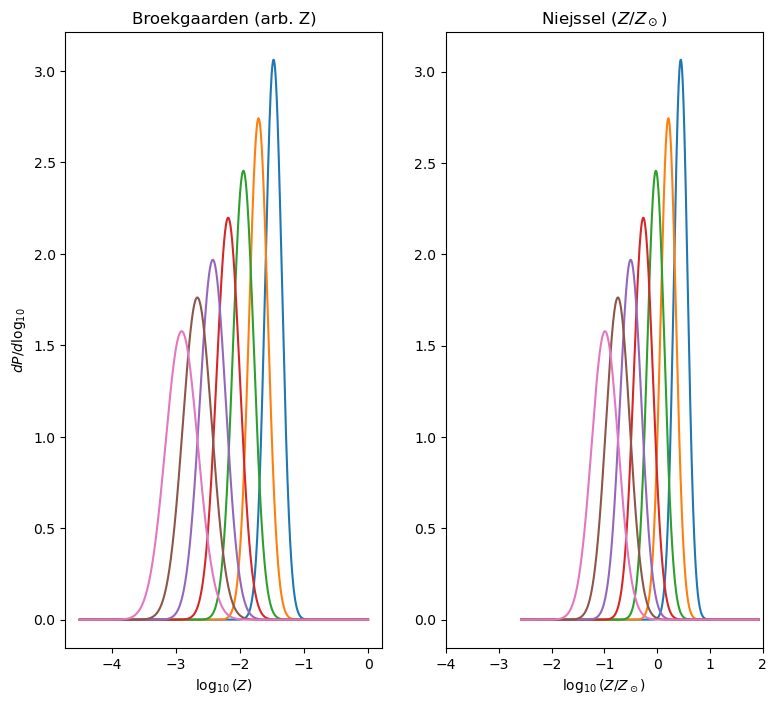

In [ ]:
# maybe copy from Floor's code

class SigmaSkew:
    def __init__(self, sigma0, sigmaz):
        self.sigma0 = sigma0
        self.sigmaz = sigmaz

def returnFractionLogNormal(Zlower, Zupper, redshift, skewoptions=None):
    """
    Instead of combining a GSMF and MZ relation
    you can also directly construct a redshift dependent metallicity distribution

    In this case we focus on a log-normal distribution

    log10(Z) is normally distributed with:

    meanM  = log(Zmean)
                This is redshift dependent and Zmean scales as
                Zmean = Z0 * 10^(alpha * redshift)
                Z0 is the mean metallicity at redshift zero
                alpha is the scaling of the redshift

    sigma  = the standard deviation of log(Z) distribution
                we assume for now that this is redshift independent

    """
    Z0       = 0.035
    alpha    = -0.23
    sigma    = 0.39
    if skewoptions is not None:
        # will also have to deal with the fact that now sigma is an array
        # and no longer a scalar
        sigma = skewoptions.sigma0*(10**(skewoptions.sigmaz*redshift))

    Zmean    = Z0 * (10**(alpha*redshift))
    mu       = np.log(Zmean)  - np.power(sigma,2) /2.
    Xupper   = (np.log(Zupper) - mu)/(float(np.sqrt(2))*sigma)
    CDFUpper = 0.5 + 0.5 * scipy.special.erf(Xupper)
    Xlower   = (np.log(Zlower) - mu)/(float(np.sqrt(2))*sigma)
    CDFLower =  0.5 + 0.5 * scipy.special.erf(Xlower)
    fraction = CDFUpper - CDFLower 
    return fraction

def fractionLogNormalCenter(Z_center, redshift_center, width, diff, options=None):
    # diff = 0.045
    return returnFractionLogNormal(
        Z_center - diff/2,
        Z_center + diff/2,
        redshift_center,
        options
    )/width

fig, (axes, comp_ax) = plt.subplots(1,2, figsize=(9,8))
# set metallicity range
zBins = np.logspace(-4.5,0.,1000)
center = (zBins[1:] + zBins[:-1])/2.
width  = np.diff(np.log10(zBins))
# print(width)
redshifts = [0, 1, 2, 3, 4, 5, 6]

for nrz, redshift in enumerate(redshifts):
    PDF = np.zeros(len(center))
    for nrZ, Z in enumerate(center):
        Zlower   = zBins[nrZ]
        Zupper   = zBins[nrZ+1]
        PDF[nrZ] = returnFractionLogNormal(Zlower, Zupper, redshift, SigmaSkew(0.3,0.048))
    PDF = np.divide(PDF, width)

    # assert np.sum(np.isclose(PDF, fractionLogNormalCenter(center, redshift)))==0
    # print(f'should be: {PDF} and is: {fractionLogNormalCenter(center, redshift)}')
    axes.plot(np.log10(center), PDF)
    comp_ax.plot(
        np.log10(center)-np.log10(0.012),
        fractionLogNormalCenter(center, redshift, 0.0045, np.diff(zBins), SigmaSkew(0.3,0.048))
    )
comp_ax.set_xlabel(r'$\log_{10}(Z/Z_\odot)$')
axes.set_xlabel(r'$\log_{10}(Z)$')
axes.set_ylabel(r'$dP/d\log_{10}$')
axes.set_title('Broekgaarden (arb. Z)')
comp_ax.set_title(r'Niejssel $(Z/Z_\odot)$')
comp_ax.set_xlim(-4, 2)
fig.show()

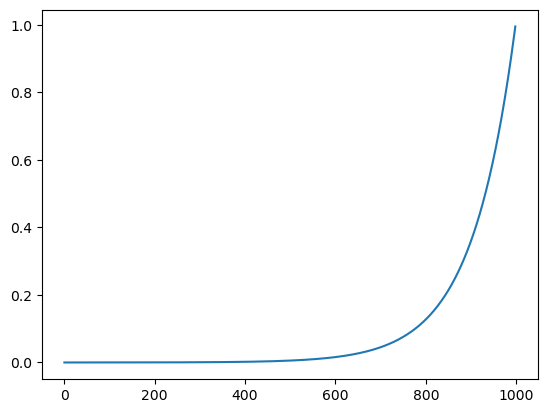

In [7]:
# also plot bins
plt.figure()
plt.plot([i for i in range(len(center))], center)
plt.show()

/var/folders/xf/4xjcxwsx60s4g6c1mw4np0z40000gn/T/ipykernel_19762/810839982.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  twodfig.show()


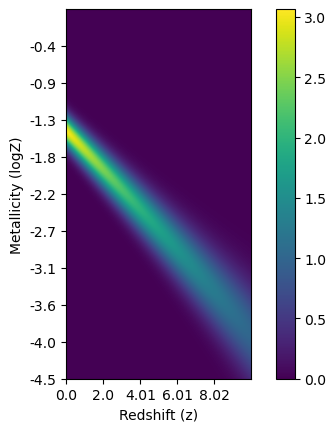

In [17]:
# ok now let's do this in 2D. if we can marginalize this correctly then we've done something right
redshift_bins = np.linspace(0, 10, 500)
Zmesh, redshiftMesh = np.meshgrid(
    center,
    redshift_bins
)
func = fractionLogNormalCenter(Zmesh, redshiftMesh, 0.0045, np.diff(zBins), SigmaSkew(0.3,0.048))
twodfig, twodax = plt.subplots(1,1)
# twodax.contour(np.log10(Zmesh), redshiftMesh, func, levels=100)
im = twodax.imshow(func.T)
twodax.invert_yaxis()

twodfig.colorbar(im)

x_ticks = np.arange(0, len(redshift_bins), 100)
twodax.set_xticks(x_ticks)
twodax.set_xticklabels(redshift_bins[x_ticks].round(2))

y_ticks = np.arange(0, len(center), 100)
twodax.set_yticks(y_ticks)
twodax.set_yticklabels(np.log10(center[y_ticks]).round(1))
# twodax.set_yscale('log')
twodax.set_xlabel('Redshift (z)')
twodax.set_ylabel('Metallicity (logZ)')
twodfig.show()